In [1]:
import cv2
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential
from tqdm import tqdm

In [2]:
images_path = "../asset/data/images/"
files = listdir(f"{images_path}banana"), listdir(f"{images_path}other")

In [3]:
def load_data():
    images_banana = np.array([cv2.imread(f"{images_path}banana/{file}") for file in files[0]], dtype="object")
    images_others = np.array([cv2.imread(f"{images_path}other/{file}") for file in files[1]], dtype="object")
    y_banana = np.ones((len(images_banana)))
    y_other = np.zeros((len(images_others)))

    X = np.hstack((images_banana, images_others))
    y = np.hstack((y_banana, y_other))
    return X, y, images_banana

def data_augmentation(imgs, new_sample_per_imgs):
    news_images = []
    augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.3),
        RandomTranslation(height_factor=0.25, width_factor=0.25, fill_mode="wrap"),
        RandomContrast(0.2)])
    for _ in tqdm(imgs):
        for i in range(new_sample_per_imgs):
            augmented = augmentation(imgs[i])
            news_images.append(np.array(augmented))
    return np.array(news_images)

def get_images_stats(images):
    shapes = []
    for img in images:
        shapes.append(img.shape)
    shapes = np.array(shapes)
    nb_samples = len(shapes)
    mean_w, mean_h = shapes[:, 0].mean(), shapes[:, 1].mean()
    median_w, median_h = np.median(shapes[:, 0]), np.median(shapes[:, 1])
    return nb_samples, (mean_w, mean_h), (median_w, mean_h)

def image_normalization(images, target_shape=(224, 224)):
    new_images = []
    for img in images:
        new_img = cv2.resize(img, target_shape)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGRA2BGR)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2RGB)
        new_img = new_img/255
        new_img = new_img[..., ::-1]
        new_images.append(new_img)
    return np.array(new_images)

def show_few_images(imgs, labels):
    randomize = np.arange(len(imgs))
    np.random.shuffle(randomize)
    _imgs = imgs[randomize]
    _labels = labels[randomize]

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=10, dpi=120)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.set_axis_off()
        ax.set_title(_labels[i])
        ax.imshow(_imgs[i])

In [4]:
X, y, images_banana = load_data()

n_samples, mean_stats, median_stats = get_images_stats(X)

print("Number of images: {nb} \nAverage stats (w,h): {mean} \nMedian stats (w,h): {median}".format(nb=n_samples, mean=tuple(map(round, mean_stats)), median=tuple(map(round, median_stats))))

Number of images: 2563 
Average stats (w,h): (280, 349) 
Median stats (w,h): (256, 349)


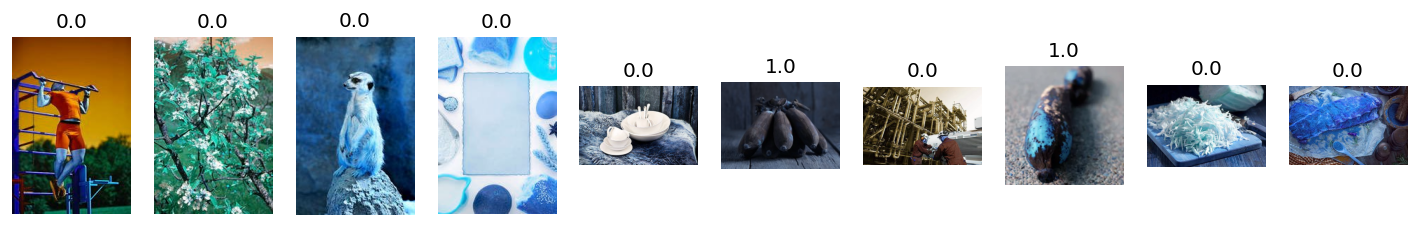

In [5]:
show_few_images(X, y)

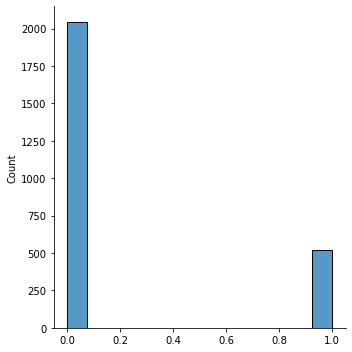

In [6]:
sns.displot(y)

In [7]:
images_banana_scaled = image_normalization(images_banana)

In [8]:
X_augmented = data_augmentation(images_banana_scaled, 3)

100%|██████████| 517/517 [00:21<00:00, 23.72it/s]


In [9]:
X_scaled = image_normalization(X)

In [10]:
X_augmented.shape, X_scaled.shape

((1551, 224, 224, 3), (2563, 224, 224, 3))

In [11]:
X_new = np.vstack((X_scaled, X_augmented))
y_new = np.hstack((y, np.ones(len(X_augmented))))
X_new.shape, y_new.shape

((4114, 224, 224, 3), (4114,))

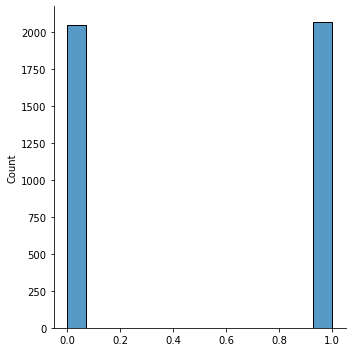

In [12]:
sns.displot(y_new)

In [13]:
n_samples, mean_stats, median_stats = get_images_stats(X_new)

print("Number of images: {nb} \nAverage stats (w,h): {mean} \nMedian stats (w,h): {median}".format(nb=n_samples, mean=tuple(map(round, mean_stats)), median=tuple(map(round, median_stats))))

Number of images: 4114 
Average stats (w,h): (224, 224) 
Median stats (w,h): (224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


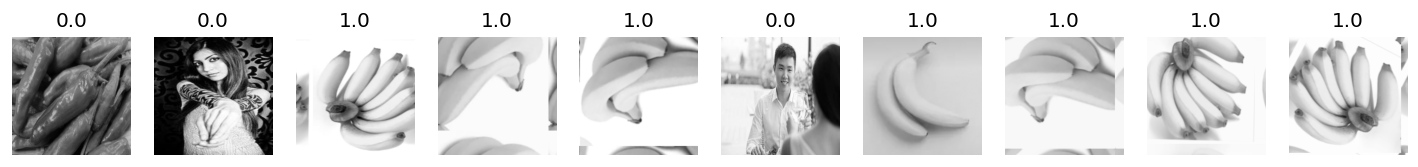

In [14]:
show_few_images(X_new, y_new)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.2)

In [16]:
X_train.shape, y_train.shape

((3291, 224, 224, 3), (3291,))

In [17]:
data = {"train": (X_train, y_train), "test": (X_test, y_test)}

In [18]:
with open(f'../asset/data/train_test_split.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)